**<h1>CONVEX OPTIMIZATION<br>HW3</h1>**

*Quang Anh NGUYEN*

# Dual problem

Consider the LASSO problem
$$
    \min_w \frac{1}{2} \left\Vert Xw-y \right\Vert_2^2 + \lambda \Vert w \Vert_1
$$

Which can be reformulated as
\begin{align*}
    \min_{w,z} \frac{1}{2}  &\left\Vert z \right\Vert_2^2 + \lambda \Vert w \Vert_1 \\
    \text{st } & z = Xw-y
\end{align*}

The Lagrangian
\begin{align*}
    L(w, z, v) &= \frac{1}{2} \left\Vert z \right\Vert_2^2 + \lambda \Vert w \Vert_1 + v^\top (Xw - y - z) \\ 
    &= \left( \frac{1}{2} \left\Vert z \right\Vert_2^2 - v^\top z \right) + \left( \lambda \Vert w \Vert _1 + v^\top X w \right) - v^\top y
\end{align*}

The dual function
\begin{align*}
    g(v) = \inf_{w, z} L(w, z, v) = 
    \begin{cases}
    -\frac{1}{2}\Vert v \Vert_2^2 - y^\top v &\text{ if } -\lambda \le X^\top v \le \lambda\\
    -\infty &\text{ otherwise }
    \end{cases}
\end{align*}

The dual problem
\begin{align*}
    \min_v  \quad &\frac{1}{2}\Vert v \Vert_2^2 + y^\top v \\
    \text{st} \quad & 
        \begin{bmatrix}
        X^\top \\ -X^\top
        \end{bmatrix}
        v \le \mathbf \lambda \mathbf 1
\end{align*}

Which is a quadratic problem, with $Q = \frac{1}{2}\mathbf I_n, A^\top = [X, -X], b=\lambda \mathbf 1_{2d}, p=y$
\begin{align*}
    \min_v \quad &v^\top Q v + p^\top v \\
    \text{st} \quad & 
        Av \le b
\end{align*}



# Barrier method

First for $t>0$, we solve the approximated problem
\begin{align*}
    \min_v   \left(v^\top Q v + p^\top v\right) - \frac{1}{t}\sum_{j=1}^{2d} \left( \log \left( b_j - A_j^\top v \right) \right)
\end{align*}
Where $A^\top = (A_1, ..., A_{2d})$, using the barrier method.

Denote this objective as $g_t(v)$. For the Newton method, we need to compute
\begin{align*}
    \nabla g_t(v) &= 2Qv + p + \sum_{j=1}^{2d} \frac{A_j}{b_j - A_j^\top v} = 2Qv + p + A^\top \phi \\ 
    \nabla^2 g_t(v) &= 2Q + \sum_{j=1}^{2d} \frac{A_j A_j^\top}{(b_j - A_j^\top v)^2} = 2Q + A^\top \mathrm{diag} (\phi)^2 A
\end{align*}

Where $\phi = \left(\frac{1}{b_j - A_j ^\top v }\right)^\top_{1\le j \le 2d}$

Then for $t\rightarrow \infty$, we approximate the solution of the dual problem above.





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rd
import time

In [ ]:
alpha = 0.4
beta = 0.5

assert alpha < 0.5
assert beta < 1

def centering_step(Q, p, A, b, t, v0, eps):
    func = lambda x: (x @ Q @ x + p @ x) - np.sum(np.log(b - A @ x))/t
    v_seq = [v0]
    v = v0

    while True:
        g = 2*Q @ v + p + A.T @ (1/(b - A @ v))/t
        H = (2*Q + A.T @ np.diag(1/(b - A @ v)**2) @ A/t)
        dv = -np.linalg.solve(H, g)
        l2 = -g @ dv

        # print('\t', l2/2)        
        if l2/2 <= eps:
            return v_seq
        
        # backtracking line search
        step_size = 1
        while True:
            # print(step_size)
            # time.sleep(0.01)
            step_size = step_size*beta
            try:
                assert (A@(v + step_size*dv) <= b).all()
                if func(v+step_size*dv) <= func(v) - alpha*step_size*l2:
                    break
            except:
                continue
            
        v = v + step_size * dv
        v_seq.append(v)
        # print(l2, v, step_size)
        # time.sleep(0.01)
    return v_seq

def barrier_method(Q, p, A, b, v0, eps):
    t = 1
    v_seq = [v0]

    while True:
        v = centering_step(Q, p, A, b, t, v_seq[-1], eps)
        v_seq = v_seq + v
        if A.shape[0] / t < eps:
            break
        t = mu*t

    return v_seq

# Application

In [ ]:
n = 50
d = 100
lbd = 10
eps = 1e-6

L = rd.rand(d, d)
m = rd.rand(d) * 2

w_true = rd.rand(d) * 6 - 3

X =  rd.randn(n, d) @ L + m[None, :]
y = X @ w_true + rd.randn(n) * 0.5

lbd = 10

In [ ]:
def dual(X, y, lbd, mu):
    Q = 1/2 * np.eye(n)
    A = np.transpose(np.concatenate((X, -X), axis=1))
    b = lbd * np.ones(2*d)
    p = y

    criterion = lambda x: x @ Q @ x + p @ x
    v0 = np.zeros(X.shape[0])

    v = barrier_method(Q, p, A, b, v0, eps)
    v = np.array(v)
    f = np.apply_along_axis(criterion, 1, v)
    return v, f

In [ ]:
%%time

mus = [2, 5, 10, 20, 50, 100, 200]
results = {}
best = np.inf

for mu in mus:
    print(r'mu={}'.format(mu))
    v, f = dual(X, y, lbd, mu)
    results[mu] = v, f
    best = min(np.min(f), best)
    

mu=2
mu=5
mu=10
mu=20
mu=50
mu=100
mu=200
CPU times: user 582 ms, sys: 375 ms, total: 957 ms
Wall time: 533 ms


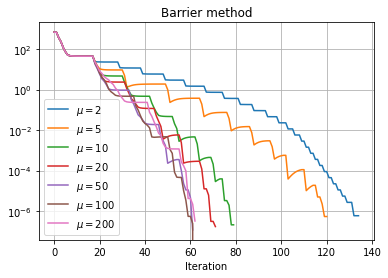

In [ ]:
for i, mu in enumerate(mus):
    v, f = results[mu]
    plt.plot(f - best, label = r'$\mu={}$'.format(mu))

plt.semilogy()
plt.xlabel('Iteration')
plt.grid()
plt.legend()
plt.title('Barrier method')
plt.show()

The plot above shows the value $f(v^t) - f^\star$ through i

We observe that different values of $\mu$ lead to different numbers of iteration to achieve the precision $\varepsilon$. However, for $\mu\ge 20$ the difference is no longer significant. We will choose $\mu=20$ for the following.

As the primal is convex, strong duality holds. We can solve $z^\star, w^\star$ by minimizing $L(z, w, v^\star)$ without constraints, which gives
\begin{align*}
    z = v = Xw - y \\
    \begin{cases}
    \mathrm{sign} w_j (X^\top v)_j < 0 &\text{ if } \vert (X^\top v)\vert =\lambda \\ w_j = 0 &\text{ otherwise}
    \end{cases} 
\end{align*}

We can thus remove some columns from $X$ and redo the regression using pseudo inverse of this new $X$.

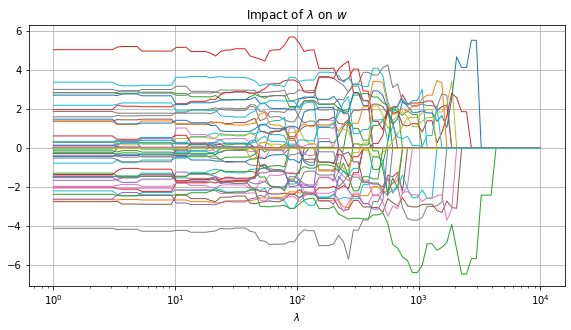

In [ ]:
mu = 20
lbds = np.logspace(0, 4, 100)
masks = np.zeros((len(lbds), d))
ws = np.zeros((len(lbds), d))

for i, lbd in enumerate(lbds):
    v, f = dual(X, y, lbd, mu)
    v = v[-1]
    mask = (np.abs(X.T @ v) - lbd)**2 < 4*eps
    masks[i] = mask
    X_ = X[:, mask]
    ws[i, mask] = np.linalg.solve(X_.T @ X_, X_.T @ y)

plt.figure(figsize=(9.6, 4.8))
plt.grid()
plt.title(r'Impact of $\lambda$ on $w$')
for i in range(d):
    plt.plot(lbds, ws[:, i], lw=1)
plt.semilogx()
plt.xlabel(r'$\lambda$')
plt.show()


The plot above shows the $w$ estimated for different values of $\lambda$.

We can observe that for small $\lambda$, $w$ stays relatively stable, which is close to the unconstraint problem. For large $\lambda$, $w$ seems to converge to 0 because the penalty term becomes more important.